In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import os
import seaborn as sns

In [2]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.analysis import parcoords

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

"""
    Parameters
    ----------
    problem_formulation_id : int {0, ..., 6}
                             problem formulations differ with respect to the objectives
                             0: Total cost, and casualties
                             1: Expected damages, costs, and casualties
                             2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
                             3: costs and casualties disaggregated over dike rings, and room for the river and evacuation costs
                             4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs
                             5: disaggregate over time and space
                             6: Same as 3 but only aggregated for Gelderland, NOTE Expected annual damage only represents Gelderland

    """
problem_formulation = 7  # Change this to the desired problem formulation ID
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

In [4]:
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)


CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [5]:
from ema_workbench import ScalarOutcome, Scenario

# List of outcomes you want to optimize
objectives = ['Expected Annual Damage', 'Expected Number of Deaths']

# # Loop over all outcomes
# for outcome in dike_model.outcomes:
#     if outcome.name in objectives:
#         outcome.kind = ScalarOutcome.MINIMIZE
#     else:
#         outcome.kind = ScalarOutcome.INFO  # neutral, will be ignored in optimization


for outcome in dike_model.outcomes:
    print(f"{outcome.name}: kind={outcome.kind}")

reference_scenario = Scenario('Reference Scenario', **dict({
    'discount rate 0': 2.5,
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
    'A.0_ID flood wave shape': 4,
    'A.1_Bmax': 175,
    'A.2_Bmax': 175,
    'A.3_Bmax': 175,
    'A.4_Bmax': 175,
    'A.5_Bmax': 175,
    'A.1_pfail': 0.5,
    'A.2_pfail': 0.5,
    'A.3_pfail': 0.5,
    'A.4_pfail': 0.5,
    'A.5_pfail': 0.5,
    'A.1_Brate': 1.5,
    'A.2_Brate': 1.5,
    'A.3_Brate': 1.5,
    'A.4_Brate': 1.5,
    'A.5_Brate': 1.5
}))



Expected Annual Damage: kind=-1
Dike Investment Costs: kind=-1
RfR Total Costs: kind=-1
Evacuation Costs: kind=-1
Expected Number of Deaths: kind=-1


In [6]:
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
convergence_metrics = [
    ArchiveLogger('./data/test_runs', [l.name for l in dike_model.levers],
                  [o.name for o in dike_model.outcomes],
                  base_filename='pf6_run.tar.gz'),
    EpsilonProgress()
]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results1, convergence = evaluator.optimize(nfe=100, searchover='levers',  epsilons=[0.5,]*len(dike_model.outcomes), reference=reference_scenario,convergence=convergence_metrics)

[MainProcess/INFO] pool started with 12 workers
100%|████████████████████████████████████████| 100/100 [00:13<00:00,  7.47it/s]
[MainProcess/INFO] optimization completed, found 7 solutions
[MainProcess/INFO] terminating pool


In [8]:
results1

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Total Costs,Evacuation Costs,Expected Number of Deaths
0,0,1,0,0,1,0,1,0,1,1,...,4,6,3,0,6,0.000000e+00,2.787667e+08,862300000.0,0,0.000000
1,0,0,1,0,0,0,1,0,1,0,...,0,2,6,0,3,3.798515e+06,5.603982e+08,146000000.0,0,0.000794
2,0,0,1,0,0,0,0,1,0,0,...,5,5,5,1,3,8.297733e+05,4.603164e+08,236500000.0,0,0.000220
3,1,1,0,0,0,0,1,0,0,0,...,2,5,2,4,5,1.171282e+07,5.566731e+08,199900000.0,0,0.010880
4,0,1,0,0,1,1,1,1,0,1,...,10,1,1,4,6,4.015117e+06,3.769315e+08,824000000.0,0,0.000562
5,0,0,0,1,0,0,1,0,0,0,...,7,5,8,0,7,0.000000e+00,3.784156e+08,369700000.0,0,0.000000
6,0,0,1,1,1,0,1,0,0,0,...,0,9,4,3,10,1.171282e+07,3.274367e+08,807000000.0,0,0.001306


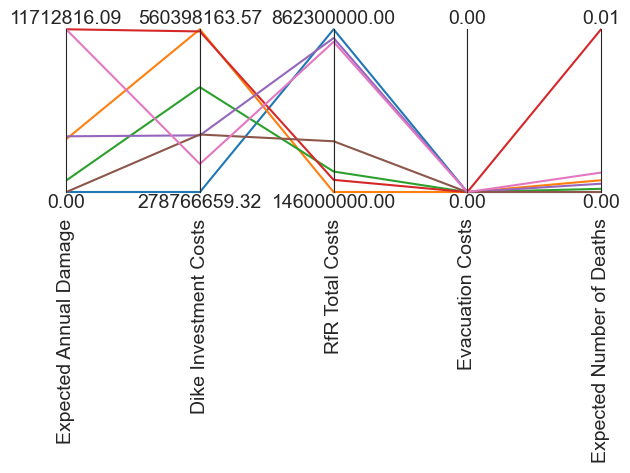

In [7]:
data = results1.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

C:\Users\sweja\PycharmProjects\Model-based\.venv\Lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


<Figure size 3000x3000 with 0 Axes>

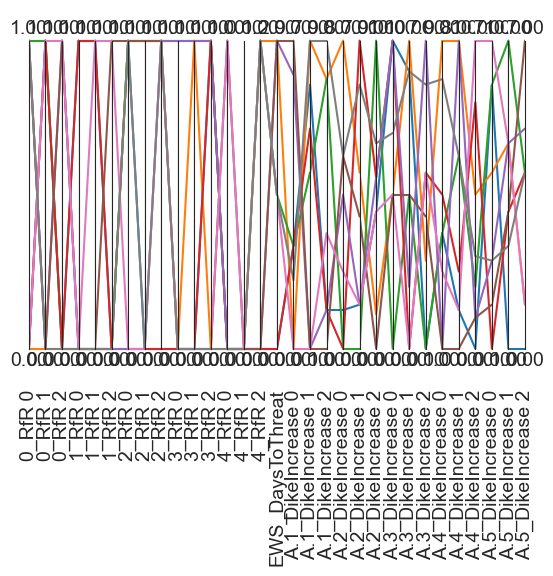

In [9]:
data2 = results1.loc[:, [o.name for o in dike_model.levers]]
limits2 = parcoords.get_limits(data2)
plt.figure(figsize=(30, 30))
paraxes = parcoords.ParallelAxes(limits2)
paraxes.plot(data2)

plt.show()

In [9]:
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import epsilon_nondominated,to_problem
# archive = ArchiveLogger.load_archives('./data/test_runs/pf6_run.tar.gz')
all_archives = []

for i in range(1):
    archives = ArchiveLogger.load_archives('./data/test_runs/pf6_run.tar.gz')
    sample_archive = list(archives.values())[0]  # pak 1e NFE-waarde
    print(sample_archive.columns)
    all_archives.append(archives)

problem = to_problem(dike_model, searchover="levers")
print("Levers expected by problem:")
print(problem.parameter_names)
print(len(problem.parameter_names))

print("\nColumns in results1:")
print(results1.columns.tolist())
print(len(results1.columns))
results = [results1]
reference_set = epsilon_nondominated(results, [0.5] * len(dike_model.outcomes), problem)

hv = HypervolumeMetric(reference_set, problem)
gd = GenerationalDistanceMetric(reference_set, problem, d=1)
ei = EpsilonIndicatorMetric(reference_set, problem)
ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
sm = SpacingMetric(problem)

metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed.append(metrics)

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'Expected Annual Damage', 'Dike Investment Costs', 'RfR Total Costs',
       'Evacuation Costs', 'Expected Number of Deaths'],
      dtype='object')
Levers expected by problem:
['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrea

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive

# **Dit hieronder is gekopieerd van de EMA website**

In [7]:
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress

# we need to store our results for each seed
results = []
convergences = []

with MultiprocessingEvaluator(dike_model) as evaluator:
    # we run again for 5 seeds
    for i in range(5):
        # we create 2 covergence tracker metrics
        # the archive logger writes the archive to disk for every x nfe
        # the epsilon progress tracks during runtime
        convergence_metrics = [
            ArchiveLogger(
                "./data/test_runs/",
                [l.name for l in dike_model.levers],
                [o.name for o in dike_model.outcomes],
                base_filename=f"{i}.tar.gz",
            ),
            EpsilonProgress(),
        ]

        result, convergence = evaluator.optimize(
            nfe=100,
            searchover="levers",
            epsilons=[0.05] * len(dike_model.outcomes),
            convergence=convergence_metrics,
            reference=reference_scenario
        )

        results.append(result)
        convergences.append(convergence)

[MainProcess/INFO] pool started with 12 workers
100%|████████████████████████████████████████| 100/100 [00:10<00:00,  9.30it/s]
[MainProcess/INFO] optimization completed, found 5 solutions
100%|████████████████████████████████████████| 100/100 [00:10<00:00,  9.12it/s]
[MainProcess/INFO] optimization completed, found 8 solutions
100%|████████████████████████████████████████| 100/100 [00:10<00:00,  9.34it/s]
[MainProcess/INFO] optimization completed, found 6 solutions
100%|████████████████████████████████████████| 100/100 [00:10<00:00,  9.17it/s]
[MainProcess/INFO] optimization completed, found 8 solutions
100%|████████████████████████████████████████| 100/100 [00:10<00:00,  9.55it/s]
[MainProcess/INFO] optimization completed, found 11 solutions
[MainProcess/INFO] terminating pool


In [9]:
all_archives = []

for i in range(5):
    archives = ArchiveLogger.load_archives(f"./data/test_runs/{i}.tar.gz")
    all_archives.append(archives)

In [12]:
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import epsilon_nondominated,to_problem

problem = to_problem(dike_model, searchover="levers")

reference_set = epsilon_nondominated(results, [0.05] * len(dike_model.outcomes), problem)

hv = HypervolumeMetric(reference_set, problem)
gd = GenerationalDistanceMetric(reference_set, problem, d=1)
ei = EpsilonIndicatorMetric(reference_set, problem)
ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
sm = SpacingMetric(problem)


metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed.append(metrics)

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive

In [ ]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

ax1, ax2, ax3, ax4, ax5, ax6 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")


sns.despine(fig)

plt.show()